In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
warnings.filterwarnings('ignore')

c:\Users\Mateo Vasquez\Desktop\Proyectos\Censo2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_scaled = pd.read_parquet('output/dataset_estandarizado_para_clustering.parquet')
print(f"\nDataset cargado: {df_scaled.shape}")
print(f"   Hogares: {df_scaled.shape[0]:,}")
print(f"   Variables: {df_scaled.shape[1]}")


Dataset cargado: (57366, 168)
   Hogares: 57,366
   Variables: 168


In [3]:
# Identificar metadata 
columnas_metadata = []
posibles_metadata = ['id', 'hogar_id', 'zona', 'departamento', 'municipio', 
                     'cluster', 'nombre_cluster', 'cluster_final']

for col in posibles_metadata:
    if col in df_scaled.columns:
        columnas_metadata.append(col)

columnas_features = [c for c in df_scaled.columns if c not in columnas_metadata]

print(f"\nDataset: {df_scaled.shape}")
print(f"Features: {len(columnas_features)}")



Dataset: (57366, 168)
Features: 168


In [4]:
print("\n" + "="*80)
print("IDENTIFICANDO VARIABLES CON ZERO-INFLATION")
print("="*80)

variables_zero_inflated = []

for col in columnas_features:
    if col in df_scaled.columns:
        # Porcentaje de ceros
        pct_zeros = (df_scaled[col] == 0).sum() / len(df_scaled) * 100
        
        if pct_zeros > 50:  # Más del 50% son ceros
            varianza = df_scaled[col].var()
            if varianza > 100:  # Y tiene alta varianza
                variables_zero_inflated.append({
                    'variable': col,
                    'pct_zeros': pct_zeros,
                    'varianza': varianza,
                    'max': df_scaled[col].max(),
                    'n_nonzero': (df_scaled[col] != 0).sum()
                })

df_zero_inflated = pd.DataFrame(variables_zero_inflated).sort_values('varianza', ascending=False)

print(f"\nVariables con zero-inflation detectadas: {len(df_zero_inflated)}")
print("\nTop variables problemáticas:")
print(df_zero_inflated.head(10).to_string(index=False))


IDENTIFICANDO VARIABLES CON ZERO-INFLATION

Variables con zero-inflation detectadas: 7

Top variables problemáticas:
              variable  pct_zeros     varianza    max  n_nonzero
ingreso_independientes  88.479239 14448.542727 800.00       6609
         monto_remesas  90.938884  4035.678807 400.00       5198
                  imnl  89.879022  3926.162750 400.00       5806
                 oimed  87.567549   940.276158 204.17       7132
                  gmsa  74.265244   562.878634 150.00      14763
               ingneto  92.882544   151.801248  91.67       4083
                  imes  97.901196   104.986601  90.00       1204


In [5]:
print("\n" + "="*80)
print("TRANSFORMANDO VARIABLES")
print("="*80)

df_transformed = df_scaled.copy()

# Transformar las top variables con zero-inflation
vars_a_transformar = df_zero_inflated['variable'].head(5).tolist()

print(f"\nAplicando transformación log1p a {len(vars_a_transformar)} variables:")

for var in vars_a_transformar:
    if var in df_transformed.columns:
        # Guardar valores originales
        original = df_transformed[var].copy()
        
        # Método simple: log1p directo sobre valores estandarizados
        # (funciona porque RobustScaler no cambia la distribución dramáticamente)
        df_transformed[var] = np.sign(original) * np.log1p(np.abs(original))
        
        print(f"   {var}:")
        print(f"      Varianza antes:  {original.var():.2f}")
        print(f"      Varianza después: {df_transformed[var].var():.2f}")
        print(f"      Reducción: {(1 - df_transformed[var].var()/original.var())*100:.1f}%")


TRANSFORMANDO VARIABLES

Aplicando transformación log1p a 5 variables:
   ingreso_independientes:
      Varianza antes:  14448.54
      Varianza después: 2.91
      Reducción: 100.0%
   monto_remesas:
      Varianza antes:  4035.68
      Varianza después: 1.99
      Reducción: 100.0%
   imnl:
      Varianza antes:  3926.16
      Varianza después: 2.05
      Reducción: 99.9%
   oimed:
      Varianza antes:  940.28
      Varianza después: 1.60
      Reducción: 99.8%
   gmsa:
      Varianza antes:  562.88
      Varianza después: 1.95
      Reducción: 99.7%


In [6]:
print("\n" + "="*80)
print("VERIFICAR DISTRIBUCIÓN DE VARIANZA")
print("="*80)

X_original = df_scaled[columnas_features].values
X_transformed = df_transformed[columnas_features].values

# Varianzas
var_original = X_original.var(axis=0)
var_transformed = X_transformed.var(axis=0)

print("\nComparación de varianza total:")
print(f"   Original:    {var_original.sum():.2f}")
print(f"   Transformado: {var_transformed.sum():.2f}")

# Variable dominante
max_var_orig = var_original.max()
max_var_trans = var_transformed.max()
prop_orig = max_var_orig / var_original.sum()
prop_trans = max_var_trans / var_transformed.sum()

print(f"\nVariable con mayor varianza:")
print(f"   Original:    {prop_orig*100:.1f}% de varianza total")
print(f"   Transformado: {prop_trans*100:.1f}% de varianza total")

if prop_trans < prop_orig:
    print(f"\n   MEJORA: Reducción de dominancia en {(prop_orig-prop_trans)*100:.1f} puntos")



VERIFICAR DISTRIBUCIÓN DE VARIANZA

Comparación de varianza total:
   Original:    24466.32
   Transformado: 563.70

Variable con mayor varianza:
   Original:    59.1% de varianza total
   Transformado: 26.9% de varianza total

   MEJORA: Reducción de dominancia en 32.1 puntos


In [7]:
print("\n" + "="*80)
print("PCA CON DATOS TRANSFORMADOS")
print("="*80)

# PCA completo
pca_full = PCA(random_state=42)
pca_full.fit(X_transformed)

varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

n_comps_90 = np.argmax(varianza_acumulada >= 0.90) + 1
n_components = max(n_comps_90, 20)

print(f"\nComponentes para 90% varianza: {n_comps_90}")
print(f"Componentes seleccionados: {n_components}")

# Aplicar PCA
pca = PCA(n_components=n_components, random_state=42)
X_pca_transformed = pca.fit_transform(X_transformed)

print(f"\nVarianza explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Verificar si una variable aún domina
loadings_pc1 = np.abs(pca.components_[0])
max_loading = loadings_pc1.max()
var_dominante = columnas_features[loadings_pc1.argmax()]

print(f"\nPC1 (varianza: {pca.explained_variance_ratio_[0]*100:.1f}%):")
print(f"   Variable con mayor loading: {var_dominante}")
print(f"   Loading: {max_loading:.4f}")

if max_loading < 0.5:
    print(f"   BUENO: Ninguna variable domina PC1")
else:
    print(f"   ALERTA: {var_dominante} aún domina")


PCA CON DATOS TRANSFORMADOS

Componentes para 90% varianza: 11
Componentes seleccionados: 20

Varianza explicada: 93.97%

PC1 (varianza: 29.2%):
   Variable con mayor loading: ingneto
   Loading: 0.8952
   ALERTA: ingneto aún domina


In [8]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL: 3 ENFOQUES")
print("="*80)

k = 5

# 1. Original (sin PCA)
print("\n1. CLUSTERING EN ESPACIO ORIGINAL (168D):")
kmeans_orig = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_orig = kmeans_orig.fit_predict(X_original)

sil_orig = silhouette_score(X_original, labels_orig, sample_size=10000)
db_orig = davies_bouldin_score(X_original, labels_orig)

print(f"   Silhouette:     {sil_orig:.4f}")
print(f"   Davies-Bouldin: {db_orig:.4f}")

# 2. PCA sin transformar
print(f"\n2. CLUSTERING EN PCA SIN TRANSFORMAR ({n_components}D):")
pca_sin_trans = PCA(n_components=n_components, random_state=42)
X_pca_sin_trans = pca_sin_trans.fit_transform(X_original)

kmeans_pca_sin = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_pca_sin = kmeans_pca_sin.fit_predict(X_pca_sin_trans)

sil_pca_sin = silhouette_score(X_pca_sin_trans, labels_pca_sin, sample_size=10000)
db_pca_sin = davies_bouldin_score(X_pca_sin_trans, labels_pca_sin)

print(f"   Silhouette:     {sil_pca_sin:.4f}")
print(f"   Davies-Bouldin: {db_pca_sin:.4f}")

# 3. PCA con transformación
print(f"\n3. CLUSTERING EN PCA CON TRANSFORMACIÓN ({n_components}D):")
kmeans_pca_trans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_pca_trans = kmeans_pca_trans.fit_predict(X_pca_transformed)

sil_pca_trans = silhouette_score(X_pca_transformed, labels_pca_trans, sample_size=10000)
db_pca_trans = davies_bouldin_score(X_pca_transformed, labels_pca_trans)

print(f"   Silhouette:     {sil_pca_trans:.4f}")
print(f"   Davies-Bouldin: {db_pca_trans:.4f}")


COMPARACIÓN FINAL: 3 ENFOQUES

1. CLUSTERING EN ESPACIO ORIGINAL (168D):
   Silhouette:     0.7385
   Davies-Bouldin: 0.5693

2. CLUSTERING EN PCA SIN TRANSFORMAR (20D):
   Silhouette:     0.7445
   Davies-Bouldin: 0.5654

3. CLUSTERING EN PCA CON TRANSFORMACIÓN (20D):
   Silhouette:     0.4150
   Davies-Bouldin: 0.9057


In [9]:
print("\n" + "="*80)
print("DECISIÓN FINAL")
print("="*80)

scores = {
    'Original': sil_orig,
    'PCA sin transformar': sil_pca_sin,
    'PCA con transformación': sil_pca_trans
}

mejor_enfoque = max(scores, key=scores.get)
mejor_score = scores[mejor_enfoque]

print(f"\nMEJOR ENFOQUE: {mejor_enfoque}")
print(f"Silhouette Score: {mejor_score:.4f}")

# Tabla comparativa
print("\n" + "-"*80)
print("TABLA COMPARATIVA:")
print("-"*80)
print(f"{'Enfoque':<30} {'Silhouette':>12} {'Davies-Bouldin':>16} {'Dimensiones':>12}")
print("-"*80)
print(f"{'Original':<30} {sil_orig:>12.4f} {db_orig:>16.4f} {X_original.shape[1]:>12}")
print(f"{'PCA sin transformar':<30} {sil_pca_sin:>12.4f} {db_pca_sin:>16.4f} {n_components:>12}")
print(f"{'PCA con transformación':<30} {sil_pca_trans:>12.4f} {db_pca_trans:>16.4f} {n_components:>12}")
print("-"*80)

# Diferencias
dif_pca_sin = ((sil_pca_sin - sil_orig) / sil_orig) * 100
dif_pca_trans = ((sil_pca_trans - sil_orig) / sil_orig) * 100

print(f"\nMEJORA RESPECTO A ORIGINAL:")
print(f"   PCA sin transformar:  {dif_pca_sin:+.2f}%")
print(f"   PCA con transformación: {dif_pca_trans:+.2f}%")


DECISIÓN FINAL

MEJOR ENFOQUE: PCA sin transformar
Silhouette Score: 0.7445

--------------------------------------------------------------------------------
TABLA COMPARATIVA:
--------------------------------------------------------------------------------
Enfoque                          Silhouette   Davies-Bouldin  Dimensiones
--------------------------------------------------------------------------------
Original                             0.7385           0.5693          168
PCA sin transformar                  0.7445           0.5654           20
PCA con transformación               0.4150           0.9057           20
--------------------------------------------------------------------------------

MEJORA RESPECTO A ORIGINAL:
   PCA sin transformar:  +0.81%
   PCA con transformación: -43.81%


In [10]:
print("\n" + "="*80)
print("UMAP - REDUCCIÓN NO LINEAL")
print("="*80)

# UMAP con configuración estándar
umap_reducer = UMAP(
    n_components=20,  # Mismo número que PCA para comparación justa
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_jobs=1
)

print("\nAplicando UMAP (esto puede tardar varios minutos)...")
X_umap = umap_reducer.fit_transform(X_original)

# Clustering con UMAP
kmeans_umap = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_umap = kmeans_umap.fit_predict(X_umap)

# Métricas
sil_umap = silhouette_score(X_umap, labels_umap, sample_size=10000)
db_umap = davies_bouldin_score(X_umap, labels_umap)

print(f"\nCLUSTERING EN UMAP (20D):")
print(f"   Silhouette:     {sil_umap:.4f}")
print(f"   Davies-Bouldin: {db_umap:.4f}")


print("\n" + "="*80)
print("TABLA COMPARATIVA COMPLETA")
print("="*80)
print(f"{'Método':<30} {'Silhouette':>12} {'Davies-Bouldin':>16} {'Dimensiones':>12}")
print("-"*80)
print(f"{'Original (168D)':<30} {sil_orig:>12.4f} {db_orig:>16.4f} {168:>12}")
print(f"{'PCA (20D)':<30} {sil_pca_sin:>12.4f} {db_pca_sin:>16.4f} {20:>12}")
print(f"{'UMAP (20D)':<30} {sil_umap:>12.4f} {db_umap:>16.4f} {20:>12}")
print("-"*80)

# Diferencias respecto a Original
dif_pca = ((sil_pca_sin - sil_orig) / sil_orig) * 100
dif_umap = ((sil_umap - sil_orig) / sil_orig) * 100

print(f"\nMEJORA RESPECTO A ORIGINAL:")
print(f"   PCA:  {dif_pca:+.2f}%")
print(f"   UMAP: {dif_umap:+.2f}%")


UMAP - REDUCCIÓN NO LINEAL

Aplicando UMAP (esto puede tardar varios minutos)...

CLUSTERING EN UMAP (20D):
   Silhouette:     0.4578
   Davies-Bouldin: 0.8516

TABLA COMPARATIVA COMPLETA
Método                           Silhouette   Davies-Bouldin  Dimensiones
--------------------------------------------------------------------------------
Original (168D)                      0.7385           0.5693          168
PCA (20D)                            0.7445           0.5654           20
UMAP (20D)                           0.4578           0.8516           20
--------------------------------------------------------------------------------

MEJORA RESPECTO A ORIGINAL:
   PCA:  +0.81%
   UMAP: -38.02%


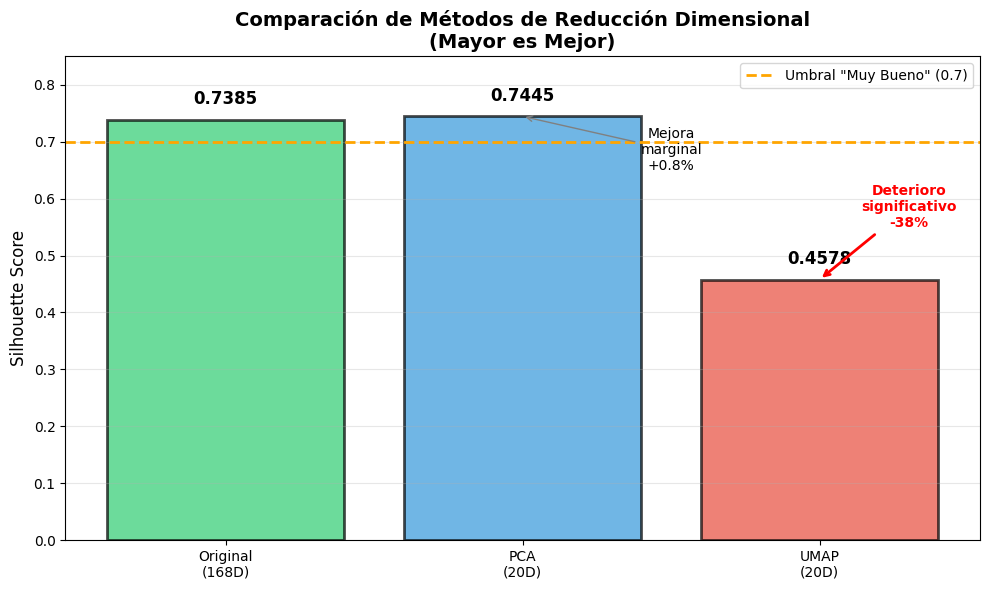

In [11]:

fig, ax = plt.subplots(figsize=(10, 6))

metodos = ['Original\n(168D)', 'PCA\n(20D)', 'UMAP\n(20D)']
silhouette = [0.7385, 0.7445, 0.4578]
colores = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, azul, rojo

bars = ax.bar(metodos, silhouette, color=colores, alpha=0.7, edgecolor='black', linewidth=2)

# Línea de referencia "muy bueno"
ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Umbral "Muy Bueno" (0.7)')

# Etiquetas en barras
for bar, val in zip(bars, silhouette):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Comparación de Métodos de Reducción Dimensional\n(Mayor es Mejor)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 0.85)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Anotaciones
ax.annotate('Mejora\nmarginal\n+0.8%', xy=(1, 0.7445), xytext=(1.5, 0.65),
            arrowprops=dict(arrowstyle='->', color='gray'),
            fontsize=10, ha='center')

ax.annotate('Deterioro\nsignificativo\n-38%', xy=(2, 0.4578), xytext=(2.3, 0.55),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_reduccion_dimensional.png', dpi=150, bbox_inches='tight')
plt.show()

In [31]:
print("\n" + "="*80)
print("GUARDAR DATASET PARA CLUSTERING")
print("="*80)

if mejor_enfoque == 'Original':
    # Usar dataset original
    df_final = df_scaled.copy()
    df_final['cluster'] = labels_orig
    filename = 'dataset_final_clustering_original.parquet'
    print(f"\nUsando dataset ORIGINAL (mejor Silhouette)")
    
elif mejor_enfoque == 'PCA sin transformar':
    # Crear dataframe con PCA sin transformar
    columnas_pca = [f'PC{i+1}' for i in range(n_components)]
    df_final = pd.DataFrame(X_pca_sin_trans, columns=columnas_pca, index=df_scaled.index)
    for col in columnas_metadata:
        if col in df_scaled.columns:
            df_final[col] = df_scaled[col].values
    df_final['cluster'] = labels_pca_sin
    filename = 'dataset_final_clustering_pca.parquet'
    print(f"\nUsando PCA SIN TRANSFORMAR (mejor Silhouette)")
    
else:  # PCA con transformación
    columnas_pca = [f'PC{i+1}' for i in range(n_components)]
    df_final = pd.DataFrame(X_pca_transformed, columns=columnas_pca, index=df_scaled.index)
    for col in columnas_metadata:
        if col in df_scaled.columns:
            df_final[col] = df_scaled[col].values
    df_final['cluster'] = labels_pca_trans
    filename = 'dataset_final_clustering_pca_transformed.parquet'
    print(f"\nUsando PCA CON TRANSFORMACIÓN (mejor Silhouette)")

# Guardar
df_final.to_parquet(f'output/{filename}', compression='snappy', index=False)

print(f"\nDataset guardado: {filename}")
print(f"   Shape: {df_final.shape}")
print(f"   Silhouette: {mejor_score:.4f}")


GUARDAR DATASET PARA CLUSTERING

Usando PCA SIN TRANSFORMAR (mejor Silhouette)

Dataset guardado: dataset_final_clustering_pca.parquet
   Shape: (57366, 21)
   Silhouette: 0.7434
